# The Dance of The Planets

Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import pandas

G = 6.67430e-11 #gravitational constant

Differential equation for two body problem:

In [2]:
def twobp(state, t, m1, m2):

    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = state

    dx = x2 - x1
    dy = y2 - y1
    r = np.sqrt(dx**2 + dy**2)
    if r < 1e-5: #in case of error division by zero
        r = 1e-5
    r3 = r**3

    ax1 = G * m2 * dx / r3
    ay1 = G * m2 * dy / r3
    ax2 = -G * m1 * dx / r3
    ay2 = -G * m1 * dy / r3

    state_dot = [vx1, vy1, vx2, vy2, ax1, ay1, ax2, ay2]
    return np.array(state_dot)

**Generating Dataset:** <br>
An important consideration while generating data was to consider real world proportionality.
Like while generating distance between two bodies for all generations it is to be considered that gravitational force won't be negligible.
For velocity it should be considered that for all generations it should not be too higher than escape velocity. For time should also be not quite small as well as large.
<br>
Hence, while generating data this all were taken under consideration. <br>
Masses were taken in range of 10 to 100.
For r in range of 0 to 1 gravitational force is not negligible.
Velocities were taken in proportion to their escape velocities.
Time was taken in proportion to time period.

Currently only one time stamp is generated for each state, but to get time dependence for each body, we will duplicate the data and add multiple time stamps for same state.

In [3]:
m1_data = np.random.uniform(10, 100, 50)
m2_data = np.random.uniform(10, 100, 50)
r_data =  np.random.uniform(0, 1, size=m1_data.shape)
v1_data = np.sqrt((G * (m1_data + m2_data) / r_data) * np.random.uniform(0, 4, size=m1_data.shape)) # escape velocity = sqrt(2*G*m/r)
v2_data = np.sqrt((G * (m1_data + m2_data) / r_data) * np.random.uniform(0, 4, size=m1_data.shape))
x1_data = np.random.uniform(-5, 5, size=m1_data.shape)
y1_data = np.random.uniform(-5, 5, size=m1_data.shape)
thetar_data =  np.random.uniform(0, 2 * np.pi, size=m1_data.shape) # theta is generated to divide into x and y components
x2_data = x1_data + r_data * np.cos(thetar_data)
y2_data = y1_data + r_data * np.sin(thetar_data)
theta1_data= np.random.uniform(0, 2 * np.pi, size=m1_data.shape)
vx1_data = v1_data * np.cos(theta1_data)
vy1_data = v1_data * np.sin(theta1_data)
theta2_data = np.random.uniform(0, 2 * np.pi, size=m1_data.shape)
vx2_data = v2_data * np.cos(theta2_data)
vy2_data = v2_data * np.sin(theta2_data)
t_data = np.sqrt( 1e-2/G*np.ones_like(m1_data))*np.random.uniform(0.5,1,50) # time period = sqrt(r3/GM)

Converting data generated into dataframe and duplicating states.

In [4]:
data = {'x1': x1_data, 'y1': y1_data, 'x2': x2_data, 'y2': y2_data, 'vx1': vx1_data, 'vy1': vy1_data, 'vx2': vx2_data, 'vy2': vy2_data, 'm1': m1_data, 'm2': m2_data}
data = pandas.DataFrame(data)
data = pd.concat([data]*50, ignore_index=True)
t_data_f = t_data.copy()
for i in range(49):
    t_data_f = np.append(t_data_f, t_data*(i+1)*0.05)
data['t'] = t_data_f

 One issue is the order of data. In SI units (currently used), the difference in order of data is quite large. To solve this issue a simple solution is to change units during propagation through neural network. <br>
 Hence, the changes are: <br>
 1. Masses: 1 unit  = 10 kg.
 2. time: 1 unit = 1e4 s.
 <br>
 This leads to velocity unit being 1 unit = 1e-4 m/s and acceleration being 1 unit = 1e-8 m/s.

In [5]:
data['vx1'] = 1e4*data['vx1']
data['vy1'] = 1e4*data['vy1']
data['vx2'] = 1e4*data['vx2']
data['vy2'] = 1e4*data['vy2']
data['m1'] = 1e-1*data['m1']
data['m2'] = 1e-1*data['m2']
data['t'] = 1e-4*data['t']

Generating trajectory of one state using `odeint` function of scipy library.

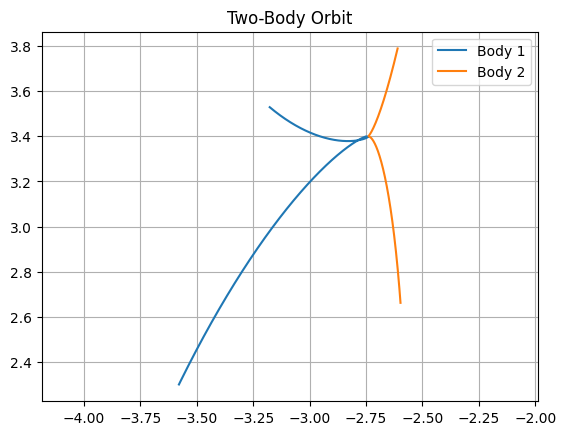

In [6]:
# reverting units of data to SI
state_0 = np.array([data.x1[0], data.y1[0], data.x2[0], data.y2[0], 1e-4*data.vx1[0], 1e-4*data.vy1[0], 1e-4*data.vx2[0], 1e-4*data.vy2[0]])
t = np.linspace(0, data.t[0], 1000)*1e4
m1 = 10*data.m1[0]
m2 = 10*data.m2[0]
sol = odeint(twobp, state_0, t, args=(m1, m2))

x1 = sol[:,0]
y1 = sol[:,1]
x2 = sol[:,2]
y2 = sol[:,3]

plt.plot(x1, y1, label='Body 1')
plt.plot(x2, y2, label='Body 2')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.title('Two-Body Orbit')
plt.show()


Adding positions at time t in dataset

In [7]:
x1t_data = []
y1t_data = []
x2t_data = []
y2t_data = []
for row in data.itertuples(index=False):
    # reverting to SI units
    state = np.array([row.x1, row.y1, row.x2, row.y2, 1e-4*row.vx1, 1e-4*row.vy1, 1e-4*row.vx2, 1e-4*row.vy2])
    m1 = 10*row.m1
    m2 = 10*row.m2
    t = 1e4*row.t
    t = np.linspace(0,t, 1000)
    sol = odeint(twobp, state, t, args=(m1, m2))
    x1t_data.append(sol[-1,0])
    y1t_data.append(sol[-1,1])
    x2t_data.append(sol[-1,2])
    y2t_data.append(sol[-1,3])
x1t_data = np.array(x1t_data)
y1t_data = np.array(y1t_data)
x2t_data = np.array(x2t_data)
y2t_data = np.array(y2t_data)
data['x1t'] = x1t_data
data['y1t'] = y1t_data
data['x2t'] = x2t_data
data['y2t'] = y2t_data

In [8]:
data.to_csv('data.csv') # saving csv file

In [9]:
data # visualizing data

,x1,y1,x2,y2,vx1,vy1,vx2,vy2,m1,m2,t,x1t,y1t,x2t,y2t
0,-3.176733,3.528593,-2.610199,3.788649,0.772774,-0.648439,-0.256070,-1.076265,1.712414,7.187212,1.153233,-3.578844,2.300292,-2.597367,2.661948
1,2.167688,4.112799,2.665590,4.543015,-0.172910,1.679364,-0.312903,-0.006687,4.355681,3.867865,1.070974,2.410551,5.742077,1.848447,4.726480
2,-2.420104,2.364522,-3.190365,2.433420,-1.317729,0.420177,-0.306607,0.744809,3.566654,2.207301,0.955736,-3.665794,3.099544,-3.505555,2.606468
3,-1.257329,4.287604,-1.711570,3.929707,-0.134418,-0.400667,-0.171217,1.628397,5.834528,8.010840,0.799889,-1.910788,4.180594,-1.450901,5.076762
4,4.625560,3.907505,4.547057,3.792817,-3.583283,0.288738,2.799466,-2.138203,9.186412,3.890987,0.832242,1.768514,3.798873,6.581505,2.837125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,3.793990,-0.683665,3.909196,-0.681814,-2.179585,-3.540163,0.868672,2.338623,5.522041,8.005375,2.230184,0.533154,-7.486158,4.742800,3.779995
2496,3.651169,4.267634,3.214102,4.213653,1.981248,0.760529,-1.423569,0.613922,5.095318,4.897024,1.828028,6.937009,5.628444,0.961318,5.366571
2497,1.333321,4.243540,1.170640,4.419923,-2.314506,-1.599802,1.300827,1.995690,2.581490,7.918808,1.822104,-2.854822,2.401683,3.531387,7.706436
2498,-0.844709,-1.040528,-1.023720,-1.801638,-1.011888,0.632039,1.409342,0.181507,8.697421,5.127894,2.787155,-3.361706,0.183761,2.389921,-0.384433


In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2) #train test split

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [12]:
X_train = train.iloc[:, :11].values
tX_train = torch.tensor(X_train, dtype=torch.float32, requires_grad=True).to(device) # requires grad is true since we need derivatives to calculate during ode loss
print(tX_train)

tensor([[-0.6799, -3.3914, -0.7734,  ...,  3.3876,  7.2642,  1.3459],
        [-0.8140,  2.0980, -1.2272,  ...,  1.3933,  7.9688,  0.8043],
        [ 3.6512,  4.2676,  3.2141,  ...,  5.0953,  4.8970,  0.8581],
        ...,
        [-3.1767,  3.5286, -2.6102,  ...,  1.7124,  7.1872,  2.3641],
        [-2.3899, -3.7789, -2.3679,  ...,  5.4282,  9.3525,  0.1186],
        [-1.5673,  0.4944, -2.1847,  ...,  5.3949,  4.5337,  0.1732]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)


In [13]:
y_train = train.iloc[:, 11:].values
ty_train = torch.from_numpy(y_train).to(device).float()
print(ty_train)

tensor([[-0.3838, -2.9977, -0.7560, -2.0603],
        [-1.0765,  2.0031, -0.5222,  1.4563],
        [ 5.2174,  4.9079,  2.1318,  4.7533],
        ...,
        [-4.0607,  0.9203, -2.5697,  1.5004],
        [-2.4598, -4.6618, -1.6900, -3.2669],
        [-1.4758,  0.2591, -2.3613, -0.0713]], device='cuda:0')


In [14]:
X_test = test.iloc[:,:11].values
tX_test = torch.tensor(X_test, dtype=torch.float32, requires_grad=True).to(device)
y_test = test.iloc[:,11:].values
ty_test = torch.tensor(y_test, dtype=torch.float32).to(device)

**Creating Neural Network** <br>
Activation function is chosen to be tanh since its double derivative is not zero (required for ode loss) unlike relu whose double derivative is zero.

In [15]:
class PINN(nn.Module):
    def __init__(self, input_dim, output_dim, n_units=100) -> None:
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, n_units),
            nn.Tanh(),
            nn.Linear(n_units, 2*n_units),
            nn.Tanh(),
            nn.Linear(2*n_units, 2*n_units),
            nn.Tanh(),
            nn.Linear(2*n_units, 2*n_units),
            nn.Tanh(),
            nn.Linear(2*n_units, 2*n_units),
            nn.Tanh(),
            nn.Linear(2*n_units, n_units),
            nn.Tanh(),
        )
        self.out = nn.Linear(n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out

    # ode loss fn
    def phy_loss(self, X):
        # separating t since we only need derivative wrt t
        t = X[:, 10].unsqueeze(1).requires_grad_(True)
        outputs = self.forward(torch.cat([X[:,:10], t], dim=1))

        x1t = outputs[:, 0].unsqueeze(1)
        y1t = outputs[:, 1].unsqueeze(1)
        x2t = outputs[:, 2].unsqueeze(1)
        y2t = outputs[:, 3].unsqueeze(1)

        # reverting to SI units
        m1 = 10*X[:, 8].unsqueeze(1)
        m2 = 10*X[:, 9].unsqueeze(1)

        # first derivatives wrt t, i.e., d/dt
        x1t_dot = torch.autograd.grad(x1t, t, grad_outputs=torch.ones_like(x1t), create_graph=True,  retain_graph=True)[0]
        x2t_dot = torch.autograd.grad(x2t, t, grad_outputs=torch.ones_like(x2t), create_graph=True,  retain_graph=True)[0]
        y1t_dot = torch.autograd.grad(y1t, t, grad_outputs=torch.ones_like(y1t), create_graph=True,  retain_graph=True)[0]
        y2t_dot = torch.autograd.grad(y2t, t, grad_outputs=torch.ones_like(y2t), create_graph=True,  retain_graph=True)[0]

        # double derivatives wrt t, i.e., d2/dt2
        # multiplying by 1e-8 to convert to SI units
        x1t_ddot = 1e-8*torch.autograd.grad(x1t_dot, t, grad_outputs=torch.ones_like(x1t), retain_graph=True)[0]
        y1t_ddot = 1e-8*torch.autograd.grad(y1t_dot, t, grad_outputs=torch.ones_like(y1t), retain_graph=True)[0]
        x2t_ddot = 1e-8*torch.autograd.grad(x2t_dot, t, grad_outputs=torch.ones_like(x2t), retain_graph=True)[0]
        y2t_ddot = 1e-8*torch.autograd.grad(y2t_dot, t, grad_outputs=torch.ones_like(y2t), retain_graph=True)[0]

        dx = x2t - x1t
        dy = y2t - y1t
        r = torch.sqrt(dx**2 + dy**2 + 1e-6)  # added 1e-6 to avoid division by zero
        # self.x1t_ddot = x1t_ddot

        # calculating expected accelerations of bodies
        ax1 = G * m2 * dx / r**3
        ay1 = G * m2 * dy / r**3
        # self.ax1 = ax1
        ax2 = G * m1 * (-dx) / r**3
        ay2 = G * m1 * (-dy) / r**3

        # calculating ode loss
        loss_x1 = torch.mean(torch.abs(x1t_ddot - ax1))
        loss_y1 = torch.mean(torch.abs(y1t_ddot - ay1))
        loss_x2 = torch.mean(torch.abs(x2t_ddot - ax2))
        loss_y2 = torch.mean(torch.abs(y2t_ddot - ay2))

        total_loss = (loss_x1 + loss_y1 + loss_x2 + loss_y2)/4
        return total_loss/G # divided by G since total_loss is negligible wrt mse loss.

Creating batches for training

In [16]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64
dataset = TensorDataset(tX_train, ty_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Initializing model

In [17]:
# Create instance of model
model = PINN(input_dim=11, output_dim=4, n_units=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-6)

Training model

In [18]:
loss = []
epochs = 1000
for epoch in range(epochs):
    for batch_X, batch_y in dataloader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # forward propagation
        outputs = model.forward(batch_X)

        # mse loss
        data_loss = nn.functional.mse_loss(outputs, batch_y)

        # ode loss
        physics_loss = model.phy_loss(batch_X)

        # Total loss
        total_loss = data_loss + physics_loss
        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0) # preventing exploding gradient issue
        optimizer.step()
    loss.append(total_loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Total Loss: {total_loss.item():.4}")
        print('ODE Loss:', physics_loss.item())

Epoch 0, Total Loss: 687.4
ODE Loss: 669.8663330078125
Epoch 100, Total Loss: 22.03
ODE Loss: 1.7828716039657593
Epoch 200, Total Loss: 14.14
ODE Loss: 2.470332622528076
Epoch 300, Total Loss: 12.07
ODE Loss: 3.250096321105957
Epoch 400, Total Loss: 7.006
ODE Loss: 3.050577163696289
Epoch 500, Total Loss: 19.24
ODE Loss: 3.436204195022583
Epoch 600, Total Loss: 8.013
ODE Loss: 3.768918752670288
Epoch 700, Total Loss: 7.033
ODE Loss: 3.3807291984558105
Epoch 800, Total Loss: 7.158
ODE Loss: 4.440489768981934
Epoch 900, Total Loss: 7.87
ODE Loss: 3.6762232780456543


Visualizing loss curve

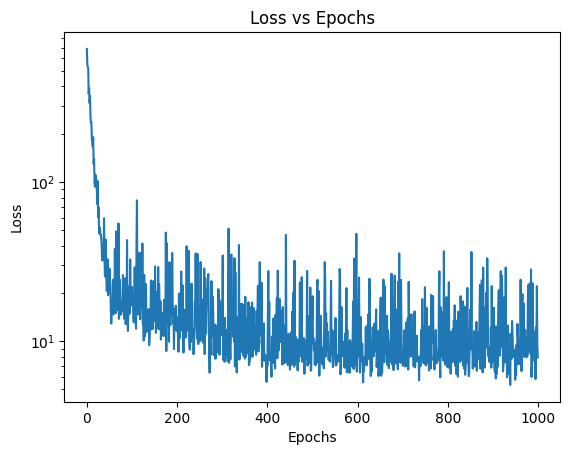

In [19]:
plt.title('Loss vs Epochs')
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')

MAE over train data

In [20]:
y_hypo = model.forward(tX_train)
print(torch.mean(torch.abs(y_hypo - ty_train)))

tensor(1.6319, device='cuda:0', grad_fn=<MeanBackward0>)


MAE over test data

In [21]:
y_hypo_test = model.forward(tX_test)
print('MAE over test data: ', torch.mean(torch.abs(ty_test - y_hypo_test)).item())

MAE over test data:  1.6045506000518799


Mean ODE residual over test data

In [22]:
odeloss = model.phy_loss(tX_test)
print('Mean ODE residual: ', odeloss.item())

Mean ODE residual:  4.5383381843566895


**Run for a given input**<br>
Recommended to use range of variables as used in dataset <br>
1. Masses: between 1 and 10 <br>
2. velocity components: each between +- 0.4 and 4
3. position components: each between -5 to 5
4. time: around 1
<br>


In [23]:
m1 = float(input('Enter mass of body 1: '))
m2 = float(input('Enter mass of body 2: '))
vx1 = float(input('Enter vx of body 1: '))
vy1 = float(input('Enter vy of body 1: '))
vx2 = float(input('Enter vx of body 2: '))
vy2 = float(input('Enter vy of body 2: '))
x1 = float(input('Enter x of body 1: '))
y1 = float(input('Enter y of body 1: '))
x2 = float(input('Enter x of body 2: '))
y2 = float(input('Enter y of body 2: '))
t = float(input('Enter time: '))

Generating actual trajectory:

In [25]:
state_0 = np.array([x1, y1, x2, y2, 1e-4*vx1, 1e-4*vy1, 1e-4*vx2, 1e-4*vy2])
t_l = np.linspace(0, t, 50)*1e4
m1 = 10*m1
m2 = 10*m2
sol = odeint(twobp, state_0, t_l, args=(m1, m2))

state_t = sol[:,0:4]

Predicting trajectory

In [32]:
state = np.array([x1, y1, x2, y2, 1e-4*vx1, 1e-4*vy1, 1e-4*vx2, 1e-4*vy2, 10*m1, 10*m2])
t_t = np.linspace(0, t, 50)
t_t = torch.tensor(t_t, dtype=torch.float32, requires_grad=True).to(device)
t_t = t_t.unsqueeze(1)
tstate = torch.tensor(state, dtype=torch.float32, requires_grad=True).to(device)
tstate = tstate.repeat(50, 1)
X_in = torch.cat([tstate, t_t], dim=1)
outputs = model.forward(X_in)

MAE:

In [33]:
outputs = outputs.detach().cpu().numpy()
mae_in = np.mean(np.abs(outputs - state_t))
print('MAE over input: ',mae_in)

MAE over input:  1.8737701114647516


Mean ODE residual:

In [30]:
odeloss_in = model.phy_loss(X_in)
print('Mean ODE residual over input: ', odeloss_in.item())

Mean ODE residual over input:  222.62741088867188
